<p style="font-size:36px;text-align:center"> <b>Case Study 2 : Personalized cancer diagnosis</b> </p>

<h1>1. Business Problem</h1>

<h6> Problem statement : </h6>
<p> Classify the given genetic variations/mutations based on evidence from text-based clinical literature. </p>

<h1>2. Machine Learning Problem Formulation</h1>

<h3>2.1.1. Data Overview</h3>

- Source: https://www.kaggle.com/c/msk-redefining-cancer-treatment/data
- We have two data files: one conatins the information about the genetic mutations and the other contains the clinical evidence (text) that  human experts/pathologists use to classify the genetic mutations. 
- Both these data files are have a common column called ID
- <p> 
    Data file's information:
    <ul> 
        <li>
        training_variants (ID , Gene, Variations, Class)
        </li>
        <li>
        training_text (ID, Text)
        </li>
    </ul>
</p>

<h2>2.2. Mapping the real-world problem to an ML problem</h2>

<p>
    
            There are nine different classes a genetic mutation can be classified into => Multi class classification problem
   
      
    
</p>

<h3>2.2.2. Performance Metric</h3>

Source: https://www.kaggle.com/c/msk-redefining-cancer-treatment#evaluation

Metric(s): 
* Multi class log-loss 
* Confusion matrix 

<h2>2.3. Train, CV and Test Datasets</h2>

 Split the dataset randomly into three parts train, cross validation and test with 64%,16%, 20% of data respectively

<h1>3. Exploratory Data Analysis</h1>

In [1]:
#Importing Libraries

import os
import warnings
import numpy as np
import pandas as pd
from nltk.corpus import stopwords
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.manifold import TSNE
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics.classification import accuracy_score, log_loss
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import SGDClassifier
from collections import Counter
from scipy.sparse import hstack
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.cross_validation import StratifiedKFold 
from collections import Counter, defaultdict
from sklearn.calibration import CalibratedClassifierCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import math
from sklearn.metrics import normalized_mutual_info_score
from sklearn.ensemble import RandomForestClassifier
warnings.filterwarnings("ignore")


from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
import matplotlib as plt

/Users/snehamehrin/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/snehamehrin/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


<h2>3.1. Reading Data</h2>

<h3>3.1.1. Reading Gene and Variation Data</h3>

In [2]:
#Importing Training Variant Data

data = pd.read_csv('training_variants.csv')

FIRST FIVE ELEMENTS


    ID    Gene             Variation  Class
0   0  FAM58A  Truncating Mutations      1
1   1     CBL                 W802*      2
2   2     CBL                 Q249E      2
3   3     CBL                 N454D      3
4   4     CBL                 L399V      4
-------------------------------------------------------------------------------------------------------------------
THERE ARE 3321 DATA POINTS  AND 4 COLUMNS
-------------------------------------------------------------------------------------------------------------------
FEATURE NAMES ARE  Index(['ID', 'Gene', 'Variation', 'Class'], dtype='object')
-------------------------------------------------------------------------------------------------------------------
COUNT OF UNIQUE COLUMNS
-------------------------------------------------------------------------------------------------------------------
   Unique Gene  Unique Variation  Unique Class
0          264              2996             9


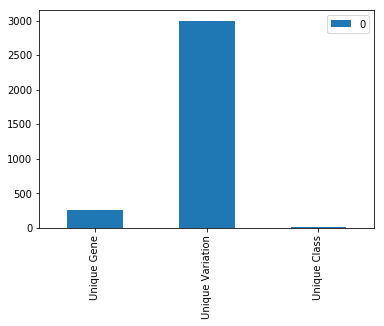

In [3]:
#Intial Feel of data

print("FIRST FIVE ELEMENTS\n\n\n",data.head())
print('-'*115)
print("THERE ARE {} DATA POINTS ".format(data.shape[0]),'AND {} COLUMNS'.format(data.shape[1]))
print('-'*115)
print("FEATURE NAMES ARE ",data.columns)
print('-'*115)
print('COUNT OF UNIQUE COLUMNS')
print('-'*115)
unique=pd.DataFrame([[len(data['Gene'].unique()),len(data['Variation'].unique()),len(data['Class'].unique())]],columns=['Unique Gene','Unique Variation','Unique Class'])
print(unique)

unique.T.plot.bar()

<p>
    training/training_variants is a comma separated file containing the description of the genetic mutations used for training. <br>
    Fields are 
    <ul>
        <li><b>ID : </b>the id of the row used to link the mutation to the clinical evidence</li>
        <li><b>Gene : </b>the gene where this genetic mutation is located </li>
        <li><b>Variation : </b>the aminoacid change for this mutations </li>
        <li><b>Class :</b> 1-9 the class this genetic mutation has been classified on</li>
    </ul>

<function matplotlib.pyplot.show(*args, **kw)>

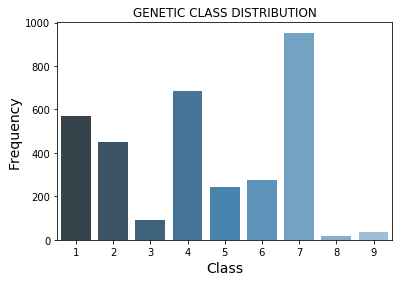

In [4]:
#Distribution of class

%matplotlib inline
import matplotlib.pyplot as plt
sns.countplot(x='Class',data=data,palette="Blues_d")
plt.xlabel('Class',fontsize=14)
plt.ylabel('Frequency',fontsize=14)
plt.title('GENETIC CLASS DISTRIBUTION')
plt.show

<h4> OBSERVATIONS </h4>

<ol>
    <li> Class 7 has the maximum number of genes</li>
    <li>Class 8 and 9 has very few</li>
 </ol>

In [5]:
#Distribution of Gene

#Gene with maximum occurence
def find_gene_frequency(x):
    gene_occurence=pd.DataFrame(x['Gene'].value_counts().reset_index())
    gene_occurence.rename(columns={'index':'Gene','Gene':'Count'},inplace=True)
    final_gene_occurence=pd.concat([gene_occurence[:10],gene_occurence[-10:]])
    return final_gene_occurence

#plot the chart

def plot_chart(chart_data,row,column):
    
    chart_data.plot.bar(x='Gene',y='Count',ax=axs[row][column])
    plt.xlabel('GENES',fontsize=14)
    plt.ylabel('FREQUENCY',fontsize=14)
    plt.title('GENE-CLASS')


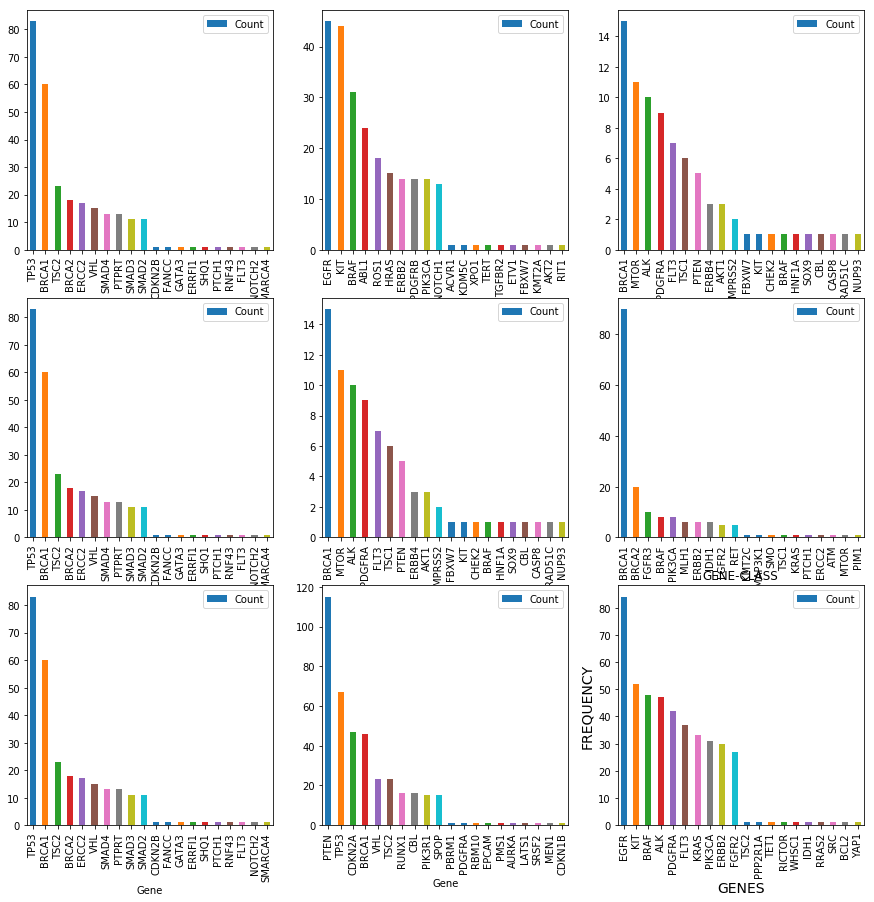

In [6]:
fig, axs = plt.subplots(ncols=3, nrows=3, figsize=(15,15))
for row in range(0,3):
        for col in range(0,3):
            gene_class=find_gene_frequency(data.loc[data['Class']==((row*col)+col+1)]) 
            plot_chart(gene_class,row,col)
            
           
    

<h3>OBSERVATIONS</h3>

BRCA1 is highly dominating Class 5

SF3B1 is highly dominating Class 9

BRCA1 and BRCA2 are dominating Class 6


<h3>3.1.2. Reading Text Data</h3>

In [7]:
#Importing Training_Text Data
data_text =pd.read_csv('/Users/snehamehrin/Desktop/Data Analytics/AppliedAiCaseStudies/Personalised Cancer/training_text.csv',sep="\|\|",engine="python",names=["ID","TEXT"],skiprows=1)

In [8]:
#Initial Feel of Data
print("FIRST FIVE ELEMENTS\n\n\n",data_text.head())
print('-'*115)
print("SHAPE OF THE DATA IS ",data_text.shape)
print('-'*115)
print("FEATURE NAMES ARE ",data_text.columns)
print('-'*115)

FIRST FIVE ELEMENTS


    ID                                               TEXT
0   0  Cyclin-dependent kinases (CDKs) regulate a var...
1   1   Abstract Background  Non-small cell lung canc...
2   2   Abstract Background  Non-small cell lung canc...
3   3  Recent evidence has demonstrated that acquired...
4   4  Oncogenic mutations in the monomeric Casitas B...
-------------------------------------------------------------------------------------------------------------------
SHAPE OF THE DATA IS  (3321, 2)
-------------------------------------------------------------------------------------------------------------------
FEATURE NAMES ARE  Index(['ID', 'TEXT'], dtype='object')
-------------------------------------------------------------------------------------------------------------------


<h3>3.1.3. Preprocessing of text</h3>

In [9]:
import re
stop_words = set(stopwords.words('english'))
def dataprocessing(x):
    #replacing special characters with space
    final_text=re.sub('[^A-Za-z0-9\n]',' ',x)
    #replace multiple spaces with single space
    final_text=re.sub('\s+',' ',final_text)
    #converting all letters into lower case
    final_text=final_text.lower()
    #removing stop words
    final_text2=[word for word in final_text.split(' ') if word not in stop_words]
    final_text2=' '.join(final_text2)
    return final_text2
data_text['TEXT']=data_text['TEXT'].astype(str).apply(dataprocessing)    

In [10]:

data_text['TEXT'].head()

0    cyclin dependent kinases cdks regulate variety...
1     abstract background non small cell lung cance...
2     abstract background non small cell lung cance...
3    recent evidence demonstrated acquired uniparen...
4    oncogenic mutations monomeric casitas b lineag...
Name: TEXT, dtype: object

In [11]:
#Renaming columns
data_text=data_text.rename(columns={'Id':'ID'})
#Merging Two Datasets to have a combined dataset
result=pd.merge(data,data_text,on='ID',how='left')

In [12]:
#First five records of the merged data
result.head()

,ID,Gene,Variation,Class,TEXT
0,0,FAM58A,Truncating Mutations,1,cyclin dependent kinases cdks regulate variety...
1,1,CBL,W802*,2,abstract background non small cell lung cance...
2,2,CBL,Q249E,2,abstract background non small cell lung cance...
3,3,CBL,N454D,3,recent evidence demonstrated acquired uniparen...
4,4,CBL,L399V,4,oncogenic mutations monomeric casitas b lineag...


In [13]:
y_true = result['Class'].values
result.Gene      = result.Gene.str.replace('\s+', '_')
result.Variation = result.Variation.str.replace('\s+', '_')

In [14]:
result['Gene'].head()

0    FAM58A
1       CBL
2       CBL
3       CBL
4       CBL
Name: Gene, dtype: object

<h3>3.1.4. Test, Train and Cross Validation Split</h3>b

<h4>3.1.4.1. Splitting data into train, test and cross validation (64:20:16)</h4>

In [15]:
# split the data into test and train by maintaining same distribution of output varaible 'y_true' [stratify=y_true]
X_train, test_df, y_train, y_test = train_test_split(result, y_true, stratify=y_true, test_size=0.2)
# split the train data into train and cross validation by maintaining same distribution of output varaible 'y_train' [stratify=y_train]
train_df, cv_df, y_train, y_cv = train_test_split(X_train, y_train, stratify=y_train, test_size=0.2)#Stratify makes sure that split occurs in the same proportion as y

In [16]:
print('Number of data points in train data:', train_df.shape[0])
print('Number of data points in test data:', test_df.shape[0])
print('Number of data points in cross validation data:', cv_df.shape[0])

Number of data points in train data: 2124
Number of data points in test data: 665
Number of data points in cross validation data: 532


<h4>3.1.4.2. Distribution of y_i's in Train, Test and Cross Validation datasets</h4>


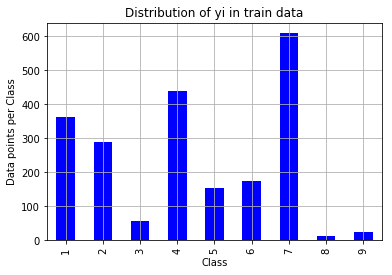

Number of data points in class 7 : 609 ( 28.672 %)
Number of data points in class 4 : 439 ( 20.669 %)
Number of data points in class 1 : 363 ( 17.09 %)
Number of data points in class 2 : 289 ( 13.606 %)
Number of data points in class 6 : 176 ( 8.286 %)
Number of data points in class 5 : 155 ( 7.298 %)
Number of data points in class 3 : 57 ( 2.684 %)
Number of data points in class 9 : 24 ( 1.13 %)
Number of data points in class 8 : 12 ( 0.565 %)
--------------------------------------------------------------------------------


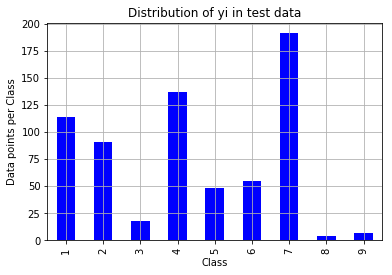

Number of data points in class 7 : 191 ( 28.722 %)
Number of data points in class 4 : 137 ( 20.602 %)
Number of data points in class 1 : 114 ( 17.143 %)
Number of data points in class 2 : 91 ( 13.684 %)
Number of data points in class 6 : 55 ( 8.271 %)
Number of data points in class 5 : 48 ( 7.218 %)
Number of data points in class 3 : 18 ( 2.707 %)
Number of data points in class 9 : 7 ( 1.053 %)
Number of data points in class 8 : 4 ( 0.602 %)
--------------------------------------------------------------------------------


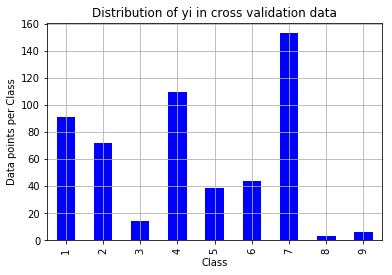

Number of data points in class 7 : 153 ( 28.759 %)
Number of data points in class 4 : 110 ( 20.677 %)
Number of data points in class 1 : 91 ( 17.105 %)
Number of data points in class 2 : 72 ( 13.534 %)
Number of data points in class 6 : 44 ( 8.271 %)
Number of data points in class 5 : 39 ( 7.331 %)
Number of data points in class 3 : 14 ( 2.632 %)
Number of data points in class 9 : 6 ( 1.128 %)
Number of data points in class 8 : 3 ( 0.564 %)


In [17]:
#sortlevel sorts the index(in this case class values) in ascending order
train_class_distribution=train_df['Class'].value_counts().sortlevel()
test_class_distribution=test_df['Class'].value_counts().sortlevel()
cv_class_distribution=cv_df['Class'].value_counts().sortlevel()


train_class_distribution.plot(kind='bar',color='b')
plt.xlabel('Class')
plt.ylabel('Data points per Class')
plt.title('Distribution of yi in train data')
plt.grid()
plt.show()

sorted_i=np.argsort(-train_class_distribution.values)

for i in sorted_i:
    print('Number of data points in class', i+1, ':',train_class_distribution.values[i], '(', np.round((train_class_distribution.values[i]/train_df.shape[0]*100), 3), '%)')
    

print('-'*80)
test_class_distribution.plot(kind='bar', color='b')
plt.xlabel('Class')
plt.ylabel('Data points per Class')
plt.title('Distribution of yi in test data')
plt.grid()
plt.show()


sorted_yi = np.argsort(-test_class_distribution.values)
for i in sorted_yi:
    print('Number of data points in class', i+1, ':',test_class_distribution.values[i], '(', np.round((test_class_distribution.values[i]/test_df.shape[0]*100), 3), '%)')

print('-'*80)
cv_class_distribution.plot(kind='bar', color='b')
plt.xlabel('Class')
plt.ylabel('Data points per Class')
plt.title('Distribution of yi in cross validation data')
plt.grid()
plt.show()


sorted_yi = np.argsort(-cv_class_distribution.values)
for i in sorted_yi:
    print('Number of data points in class', i+1, ':',cv_class_distribution.values[i], '(', np.round((cv_class_distribution.values[i]/cv_df.shape[0]*100), 3), '%)')


<h4>Observations</h4>

We see that class 7 has highest number of data points in all the data set

It looks like an imbalanced data set

<h2>3.3 Feature Engineering </h2>

##Response Encoding Algorithm explained

1) Consider all unique occurrences of the feature

2) Convert the feature into a 1*9 vector(with index as feature items and columns as classes)

3)First Element of this vector will be (no of times this feature occured in class 1 + alpha*10/no of times this 
feature occured in entire dataset + alpha*90)

4)Store it in a dictinary with keys as feature names and values as the probability 

5)Pass the test,training or cv dataset through a loop and check if the feature exists in the training data

6) If it exists, get the corresponding probability vector from the dictionary

7)Otherwise append 1/9

<h2>3.3.1 Sample code for response feature  </h2>

In [19]:
#1)Consider all unique occurrences of the feature
value_count=train_df['Gene'].value_counts()
print(value_count)

BRCA1     164
TP53       99
EGFR       91
BRCA2      80
PTEN       80
KIT        64
BRAF       56
ALK        48
PIK3CA     46
CDKN2A     41
PDGFRA     38
FLT3       37
ERBB2      36
KRAS       35
FGFR2      31
MTOR       29
TSC2       28
RET        28
MAP2K1     28
MLH1       23
FGFR3      23
JAK2       22
SMAD4      21
NOTCH1     21
VHL        20
MET        20
CTNNB1     20
AKT1       16
ROS1       16
ABL1       16
         ... 
RRAS2       1
FANCC       1
RAD51C      1
RHEB        1
FGF19       1
FOXP1       1
RYBP        1
SETD2       1
XPO1        1
PIK3R3      1
FGF3        1
GATA3       1
NPM1        1
GNA11       1
BARD1       1
WHSC1       1
IDH2        1
VEGFA       1
RAD51B      1
SHQ1        1
FAM58A      1
AXIN1       1
MDM2        1
SRSF2       1
NCOR1       1
LATS2       1
PMS1        1
MEN1        1
GLI1        1
PBRM1       1
Name: Gene, Length: 234, dtype: int64


In [20]:
#2)Build a Vector 1*9(First Element =(number of times it occured in class1 + 10*alpha / number of time it occurred in total data+90*alpha

#Build a dictionary to hold the key value pairs(Key=Gene Feature names, Values=1*9 Vector corresponding to that feature)
gv_dict=dict()
#Here i gives the Gene Feature Name and denominator gives total times that Gene occurs in the training dataset
for i,denominator in value_count.items():
    vec=[]
    for k in range(1,10):
        #cls_count stores all the data which has rows with one particular Gene Name and belonging to one Class
        cls_cnt=train_df.loc[(train_df['Class']==k) & (train_df['Gene']==i)]
        #cls_Cnt.shape[0] wil give total no of times that Gene occured in that particular class
        vec.append((cls_cnt.shape[0] + 1*10)/ (denominator + 90*1))
    #Store it in a dictionary with key value pairs((Key=Gene Feature names, Values=1*9 Vector corresponding to that feature))
    gv_dict[i]=vec

In [21]:
#Pass the test,training or cv df through a loop and for every feature in the data and check if it exists in the training data
#value_count is like a dictionary
value_count=train_df['Gene'].value_counts()
#loop through each rows of the dataset
gv_fea=[]
for index,row in test_df.iterrows():
    #Wherever Gene Feature is there in training data set,lookup the corresponding probability vector corresponding to that Gene Feature
    if row['Gene'] in dict(value_count).keys():
        gv_fea.append(gv_dict[row['Gene']])
    else:
        gv_fea.append([1/9,1/9,1/9,1/9,1/9,1/9,1/9,1/9,1/9])

<h2>3.3.2 Response Coding : General Algorithm </h2>

In [22]:
# code for response coding with Laplace smoothing.
# alpha : used for laplace smoothing
# feature: ['gene', 'variation']
# df: ['train_df', 'test_df', 'cv_df']
# algorithm
# ----------
# Consider all unique values and the number of occurances of given feature in train data dataframe
# build a vector (1*9) , the first element = (number of times it occured in class1 + 10*alpha / number of time it occurred in total data+90*alpha)
# gv_dict is like a look up table, for every gene it store a (1*9) representation of it
# for a value of feature in df:
# if it is in train data:
# we add the vector that was stored in 'gv_dict' look up table to 'gv_fea'
# if it is not there is train:
# we add [1/9, 1/9, 1/9, 1/9,1/9, 1/9, 1/9, 1/9, 1/9] to 'gv_fea'
# return 'gv_fea'
# ----------------------

# get_gv_fea_dict: Get Gene varaition Feature Dict
def get_gv_fea_dict(alpha, feature, df):
    # value_count: it contains a dict like
    # print(train_df['Gene'].value_counts())
    # output:
    #        {BRCA1      174
    #         TP53       106
    #         EGFR        86
    #         BRCA2       75
    #         PTEN        69
    #         KIT         61
    #         BRAF        60
    #         ERBB2       47
    #         PDGFRA      46
    #         ...}
    # print(train_df['Variation'].value_counts())
    # output:
    # {
    # Truncating_Mutations                     63
    # Deletion                                 43
    # Amplification                            43
    # Fusions                                  22
    # Overexpression                            3
    # E17K                                      3
    # Q61L                                      3
    # S222D                                     2
    # P130S                                     2
    # ...
    # }
    value_count = train_df[feature].value_counts()
    
    # gv_dict : Gene Variation Dict, which contains the probability array for each gene/variation
    gv_dict = dict()
    
    # denominator will contain the number of time that particular feature occured in whole data
    for i, denominator in value_count.items():
        # vec will contain (p(yi==1/Gi) probability of gene/variation belongs to perticular class
        # vec is 9 diamensional vector
        vec = []
        for k in range(1,10):
            # print(train_df.loc[(train_df['Class']==1) & (train_df['Gene']=='BRCA1')])
            #         ID   Gene             Variation  Class  
            # 2470  2470  BRCA1                S1715C      1   
            # 2486  2486  BRCA1                S1841R      1   
            # 2614  2614  BRCA1                   M1R      1   
            # 2432  2432  BRCA1                L1657P      1   
            # 2567  2567  BRCA1                T1685A      1   
            # 2583  2583  BRCA1                E1660G      1   
            # 2634  2634  BRCA1                W1718L      1   
            # cls_cnt.shape[0] will return the number of rows

            cls_cnt = train_df.loc[(train_df['Class']==k) & (train_df[feature]==i)]
            
            # cls_cnt.shape[0](numerator) will contain the number of time that particular feature occured in whole data
            vec.append((cls_cnt.shape[0] + alpha*10)/ (denominator + 90*alpha))

        # we are adding the gene/variation to the dict as key and vec as value
        gv_dict[i]=vec
    return gv_dict

# Get Gene variation feature
def get_gv_feature(alpha, feature, df):
    # print(gv_dict)
    #     {'BRCA1': [0.20075757575757575, 0.03787878787878788, 0.068181818181818177, 0.13636363636363635, 0.25, 0.19318181818181818, 0.03787878787878788, 0.03787878787878788, 0.03787878787878788], 
    #      'TP53': [0.32142857142857145, 0.061224489795918366, 0.061224489795918366, 0.27040816326530615, 0.061224489795918366, 0.066326530612244902, 0.051020408163265307, 0.051020408163265307, 0.056122448979591837], 
    #      'EGFR': [0.056818181818181816, 0.21590909090909091, 0.0625, 0.068181818181818177, 0.068181818181818177, 0.0625, 0.34659090909090912, 0.0625, 0.056818181818181816], 
    #      'BRCA2': [0.13333333333333333, 0.060606060606060608, 0.060606060606060608, 0.078787878787878782, 0.1393939393939394, 0.34545454545454546, 0.060606060606060608, 0.060606060606060608, 0.060606060606060608], 
    #      'PTEN': [0.069182389937106917, 0.062893081761006289, 0.069182389937106917, 0.46540880503144655, 0.075471698113207544, 0.062893081761006289, 0.069182389937106917, 0.062893081761006289, 0.062893081761006289], 
    #      'KIT': [0.066225165562913912, 0.25165562913907286, 0.072847682119205295, 0.072847682119205295, 0.066225165562913912, 0.066225165562913912, 0.27152317880794702, 0.066225165562913912, 0.066225165562913912], 
    #      'BRAF': [0.066666666666666666, 0.17999999999999999, 0.073333333333333334, 0.073333333333333334, 0.093333333333333338, 0.080000000000000002, 0.29999999999999999, 0.066666666666666666, 0.066666666666666666],
    #      ...
    #     }
    gv_dict = get_gv_fea_dict(alpha, feature, df)
    # value_count is similar in get_gv_fea_dict
    value_count = train_df[feature].value_counts()
    
    # gv_fea: Gene_variation feature, it will contain the feature for each feature value in the data
    gv_fea = []
    # for every feature values in the given data frame we will check if it is there in the train data then we will add the feature to gv_fea
    # if not we will add [1/9,1/9,1/9,1/9,1/9,1/9,1/9,1/9,1/9] to gv_fea
    for index, row in df.iterrows():
        if row[feature] in dict(value_count).keys():
            gv_fea.append(gv_dict[row[feature]])
        else:
            gv_fea.append([1/9,1/9,1/9,1/9,1/9,1/9,1/9,1/9,1/9])
#             gv_fea.append([-1,-1,-1,-1,-1,-1,-1,-1,-1])
    return gv_fea

<h3>4 Univariate Analysis on Gene Feature</h3>

<p style="font-size:18px;"> <b>Q1.</b> Gene, What type of feature it is ?</p>
<p style="font-size:16px;"><b>Ans.</b> Gene is a categorical variable </p>
<p style="font-size:18px;"> <b>Q2.</b> How many categories are there and How they are distributed?</p>



In [23]:
unique_categories=train_df['Gene'].value_counts()
print("Unique Categories of Gene",unique_categories.shape[0])

Unique Categories of Gene 234


In [24]:
print("Top 10 categories of genes \n\n", unique_categories.head())

Top 10 categories of genes 

 BRCA1    164
TP53      99
EGFR      91
BRCA2     80
PTEN      80
Name: Gene, dtype: int64


In [25]:

#Sum of frequencies
s=sum(unique_categories.values)
print("sum of unique values")

#Relative Frequencies
h=(unique_categories.values/s)*100
print("Relative Frequency",h)

sum of unique values
Relative Frequency [7.7212806  4.66101695 4.28436911 3.76647834 3.76647834 3.01318267
 2.63653484 2.25988701 2.16572505 1.93032015 1.78907721 1.74199623
 1.69491525 1.64783427 1.45951036 1.3653484  1.31826742 1.31826742
 1.31826742 1.08286252 1.08286252 1.03578154 0.98870056 0.98870056
 0.94161959 0.94161959 0.94161959 0.75329567 0.75329567 0.75329567
 0.75329567 0.70621469 0.70621469 0.70621469 0.65913371 0.65913371
 0.65913371 0.65913371 0.65913371 0.65913371 0.65913371 0.61205273
 0.61205273 0.61205273 0.56497175 0.56497175 0.56497175 0.56497175
 0.51789077 0.51789077 0.51789077 0.51789077 0.47080979 0.42372881
 0.42372881 0.42372881 0.42372881 0.42372881 0.42372881 0.37664783
 0.37664783 0.37664783 0.37664783 0.37664783 0.37664783 0.37664783
 0.37664783 0.32956685 0.32956685 0.32956685 0.32956685 0.32956685
 0.32956685 0.32956685 0.32956685 0.32956685 0.28248588 0.28248588
 0.28248588 0.28248588 0.28248588 0.28248588 0.28248588 0.28248588
 0.2354049  0.2354049 

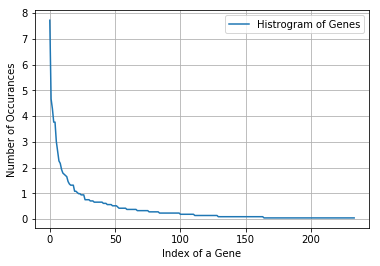

In [26]:
#Plotting Histogram

import matplotlib.pyplot as plt 
plt.plot(h, label="Histrogram of Genes")
plt.xlabel('Index of a Gene') 
plt.ylabel('Number of Occurances') 
plt.legend() 
plt.grid() 
plt.show()

<h3>Observations</h3>



<p style="font-size:12px;"> Data is skewed</p>
<p style="font-size:12px;">Top 50 points occur 80%</p>
<p style="font-size:12px;">There are many points which occur very rarely</p>



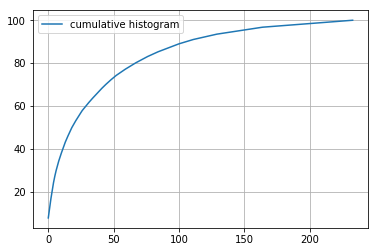

In [27]:
#Cumulative histogram

c=np.cumsum(h)
plt.plot(c,label="cumulative histogram")
plt.grid()
plt.legend()
plt.show()

<h3>Observations</h3>

<p style="font-size:12px;">Top 50 points constitute 80% of the data</p>

<p style="font-size:18px;"> <b>Q3.</b> How can we featurize Gene</p>


There are two ways we can featurize this variable:

1) One hot Encoding

2) Response coding

We will choose the appropriate featurization based on the ML model we use. For this problem of multi-class classification with categorical features, one-hot encoding is better for Logistic regression while response coding is better for Random Forests

In [28]:
#response-coding of the Gene feature
# alpha is used for laplace smoothing
alpha = 1
# train gene feature
train_gene_feature_responseCoding = np.array(get_gv_feature(alpha, "Gene", train_df))
# test gene feature
test_gene_feature_responseCoding = np.array(get_gv_feature(alpha, "Gene", test_df))
# cross validation gene feature
cv_gene_feature_responseCoding = np.array(get_gv_feature(alpha, "Gene", cv_df))

In [29]:
#One hot Encoding Gene 
gene_vectorizer=CountVectorizer()
train_gene_vectorizer=gene_vectorizer.fit_transform(train_df['Gene'])
test_gene_vectorizer=gene_vectorizer.transform(test_df['Gene'])
cv_gene_vectorizer=gene_vectorizer.transform(cv_df['Gene'])

In [30]:
#Shape of One Hot Encoding Gene Feature
print("Dimensions of One hot encoding Gene Feature", train_gene_vectorizer.shape)

Dimensions of One hot encoding Gene Feature (2124, 234)


<p style="font-size:18px;"> <b>Q4.</b> How good is this gene feature  in predicting y_i?</p>


Best evaluate a feature is to build a machine learning model on it and assess its accuracy or loss factor

In [31]:
#Building an SGD Classifier

alpha=[10 ** x for x in range(-5,1)]

cv_log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_gene_vectorizer, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_gene_vectorizer, y_train)
    predict_y = sig_clf.predict_proba(cv_gene_vectorizer)
    cv_log_error_array.append(log_loss(y_cv, predict_y,labels=clf.classes_,eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))


For values of alpha =  1e-05 The log loss is: 1.3617563169219828
For values of alpha =  0.0001 The log loss is: 1.1797530822668212
For values of alpha =  0.001 The log loss is: 1.1729593242856056
For values of alpha =  0.01 The log loss is: 1.2755499387332243
For values of alpha =  0.1 The log loss is: 1.3808649069541667
For values of alpha =  1 The log loss is: 1.4262126497746164


0 1.362
1 1.18
2 1.173
3 1.276
4 1.381
5 1.426


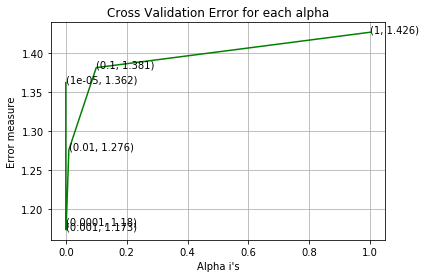

In [32]:
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    print(i,txt)
fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

In [33]:
#Finding the best alpha

best_alpha=np.argmin(cv_log_error_array)
print(best_alpha)

#SGD classifier with best alpha

clf=SGDClassifier(alpha=alpha[best_alpha],penalty='l2',random_state=42,loss='log')
clf.fit(train_gene_vectorizer,y_train)
sig_clf=CalibratedClassifierCV(clf,method='sigmoid')
sig_clf.fit(train_gene_vectorizer,y_train)


#Log Loss for Train,Test and CV data

predict_y = sig_clf.predict_proba(train_gene_vectorizer)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_gene_vectorizer)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_gene_vectorizer)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))



2
For values of best alpha =  0.001 The train log loss is: 1.087087910801018
For values of best alpha =  0.001 The cross validation log loss is: 1.1729593242856056
For values of best alpha =  0.001 The test log loss is: 1.2711976972185137


<h3>3.2.2 Univariate Analysis on Variation Feature</h3>

In [34]:
#Initial Feel of the data
print(train_df.head())
print(train_df['Variation'].head())

        ID   Gene Variation  Class  \
1234  1234   PIM1     E142D      6   
1915  1915    SMO     V321M      7   
704    704  ERBB2      L49H      5   
1448  1448   SPOP     F102C      4   
724    724  ERBB2     C334S      7   

                                                   TEXT  
1234  pim 1 kinase serine threonine protein kinase e...  
1915   basal activities adenylate cyclase guanylate ...  
704   assessed somatic alleles six receptor tyrosine...  
1448  largest e3 ligase subfamily cul3 binds btb dom...  
724   assessed somatic alleles six receptor tyrosine...  
1234    E142D
1915    V321M
704      L49H
1448    F102C
724     C334S
Name: Variation, dtype: object


<p style="font-size:18px;"> <b>Q7.</b> Variation, What type of feature is it ?</p>

<p style="font-size:16px;"><b>Ans.</b> Variation is a categorical variable </p>

<p style="font-size:18px;"> <b>Q8.</b> How many categories are there?</p>

In [35]:
unique_variations=train_df['Variation'].value_counts()
print("There are",unique_variations.shape[0],"catgories of variations")
print("\n\n\n\ Top 10 Categories of Variation are \n\n\n",unique_variations.head(10))


There are 1930 catgories of variations



\ Top 10 Categories of Variation are 


 Deletion                52
Truncating_Mutations    51
Amplification           42
Fusions                 23
Overexpression           5
E330K                    2
G12D                     2
Y64A                     2
P130S                    2
G12C                     2
Name: Variation, dtype: int64


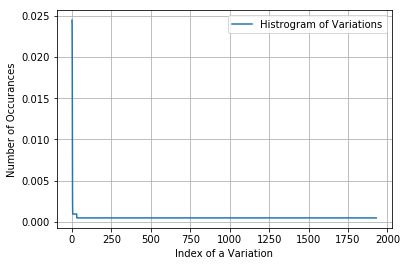

In [36]:
s = sum(unique_variations.values);
h = unique_variations.values/s;
plt.plot(h, label="Histrogram of Variations")
plt.xlabel('Index of a Variation')
plt.ylabel('Number of Occurances')
plt.legend()
plt.grid()
plt.show()

[0.02448211 0.04849341 0.06826742 ... 0.99905838 0.99952919 1.        ]


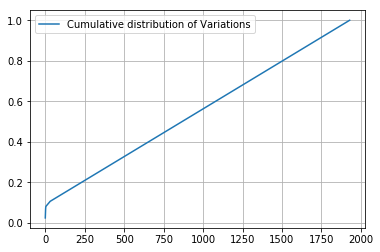

In [37]:
c = np.cumsum(h)
print(c)
plt.plot(c,label='Cumulative distribution of Variations')
plt.grid()
plt.legend()
plt.show()

<p style="font-size:18px;"> <b>Q9.</b> How to featurize this Variation feature ?</p>

<p style="font-size:16px;"><b>Ans.</b>There are two ways we can featurize this variableb
<ol><li>One hot Encoding</li><li>Response coding</li></ol></p>
<p> We will be using both these methods to featurize the Variation Feature </p>

In [38]:
# alpha is used for laplace smoothing
alpha = 1
# train gene feature
train_variation_feature_responseCoding = np.array(get_gv_feature(alpha, "Variation", train_df))
# test gene feature
test_variation_feature_responseCoding = np.array(get_gv_feature(alpha, "Variation", test_df))
# cross validation gene feature
cv_variation_feature_responseCoding = np.array(get_gv_feature(alpha, "Variation", cv_df))

In [39]:
#One hot encoding
variation_vectorizer=CountVectorizer()
train_variation_onehotencoding=variation_vectorizer.fit_transform(train_df['Variation'])
cv_variation_onehotencoding=variation_vectorizer.transform(cv_df['Variation'])
test_vectorizer_onehotencoding=variation_vectorizer.transform(test_df['Variation'])

<p style="font-size:18px;"> <b>Q10.</b> How good is this Variation feature  in predicting y_i?</p>

We will build a machine learning model using SGDClassifier to find the effectiveness of this feature

In [40]:
#Logistic Regression with SGD Classifier
alpha=[10** x for x in range(-5,1)]

for i in alpha :
    clf=SGDClassifier(alpha=i,penalty='l2',loss='log',random_state=42)
    clf.fit(train_variation_onehotencoding,y_train)
    #Calibrated classifier is used to predict probability instead of a class value
    sgd_clf=CalibratedClassifierCV(clf,method='sigmoid')
    sgd_clf.fit(train_variation_onehotencoding,y_train)
    y_predict=sgd_clf.predict_proba(cv_variation_onehotencoding)
    cv_log_error_array.append(log_loss(y_cv,y_predict,labels=clf.classes_, eps=1e-15))
    print("Log Loss for",i,"is",log_loss(y_cv, y_predict, labels=clf.classes_, eps=1e-15))

    
    
    


Log Loss for 1e-05 is 1.7304288077031402
Log Loss for 0.0001 is 1.731965096302014
Log Loss for 0.001 is 1.7345504638632698
Log Loss for 0.01 is 1.740872456970578
Log Loss for 0.1 is 1.7497894400020293
Log Loss for 1 is 1.7496214883072303


In [41]:
#Find the best alpha
best_alpha=np.argmin(cv_log_error_array)
clf=SGDClassifier(alpha=alpha[best_alpha],penalty='l2',loss='log',random_state=42)
clf.fit(train_variation_onehotencoding,y_train)
sgd_clf=CalibratedClassifierCV(clf,method='sigmoid')
sgd_clf.fit(train_variation_onehotencoding,y_train)
#Predict on Train data
y_predict=sgd_clf.predict_proba(train_variation_onehotencoding)
print("Log Loss for Train Data is ",log_loss(y_train, y_predict, labels=clf.classes_, eps=1e-15))
#Pred
y_predict=sgd_clf.predict_proba(cv_variation_onehotencoding)
print("Log Loss for CV Data is ",log_loss(y_cv, y_predict, labels=clf.classes_, eps=1e-15))

y_predict=sgd_clf.predict_proba(test_vectorizer_onehotencoding)
print("Log Loss for Test Data is ",log_loss(y_test, y_predict, labels=clf.classes_, eps=1e-15))



    
    

Log Loss for Train Data is  1.0480774482191206
Log Loss for CV Data is  1.7345504638632698
Log Loss for Test Data is  1.6808452769866282


<h3>3.2.3 Univariate Analysis on Text Feature</h3>

1)How many unique words are present in train data?


In [42]:
# building a CountVectorizer with all the words that occured minimum 3 times in train data
text_vectorizer = CountVectorizer(min_df=3)

train_text_feature_onehotCoding = text_vectorizer.fit_transform(train_df['TEXT'].fillna(''))
# getting all the feature names (words)
train_text_features= text_vectorizer.get_feature_names()
# train_text_feature_onehotCoding.sum(axis=0).A1 will sum every row and returns (1*number of features) vector
train_text_fea_counts = train_text_feature_onehotCoding.sum(axis=0).A1
# zip(list(text_features),text_fea_counts) will zip a word with its number of times it occured
text_fea_dict = dict(zip(list(train_text_features),train_text_fea_counts))
print("Total number of unique words in train data :", len(train_text_features))



Total number of unique words in train data : 52867


 2) How are they distributed

In [43]:
#Convert dictionary into tuples using dict.items
#sort the dictionary using the second element of the tuple, which is the count

sorted_dict=dict(sorted(text_fea_dict.items(),key=lambda x: x[1],reverse=True))
print(sorted_dict)
#Get only the values
sorted_text_occur = np.array(list(sorted_dict.values()))
print(sorted_text_occur)
#Here only 5300 words occured three times and so on
print(Counter(sorted_text_occur))

{'mutations': 147014, 'cells': 117494, 'cell': 79339, 'fig': 66770, 'et': 66620, 'al': 66522, 'mutation': 65947, 'figure': 61420, 'cancer': 60950, 'patients': 54753, 'protein': 53548, 'expression': 49209, 'activity': 48154, 'mutant': 45993, 'type': 45346, 'tumor': 43844, 'variants': 41917, 'domain': 41785, 'also': 41675, 'kinase': 41373, 'binding': 39998, 'using': 39807, 'gene': 38547, 'data': 37882, 'analysis': 37283, 'brca1': 36757, 'wild': 35834, '10': 35400, 'dna': 35117, 'egfr': 34431, 'mutants': 33059, 'two': 32869, 'tumors': 32563, 'table': 32119, 'activation': 31927, 'may': 30606, 'ras': 29964, 'results': 29162, 'shown': 27903, 'proteins': 25812, 'exon': 25579, 'one': 25432, 'genes': 25190, 'associated': 25055, 'used': 24482, 'growth': 24413, 'kit': 24161, 'human': 24072, 'p53': 24004, 'identified': 23568, 'found': 23500, 'function': 23466, 'study': 23332, 'clinical': 21963, 'signaling': 21960, 'levels': 21795, '20': 21692, 'lines': 21270, 'functional': 20762, 'observed': 20725

<h3>3.2.4 Featurization of Text <h3>
<h4>3.2.4.1 One Hot Encoding <h4>

In [44]:
#Using One Hot Encoding
train_text_feature_onehotCoding = text_vectorizer.fit_transform(train_df['TEXT'].fillna(''))
# don't forget to normalize every feature
train_text_feature_onehotCoding = normalize(train_text_feature_onehotCoding, axis=0)

# we use the same vectorizer that was trained on train data
test_text_feature_onehotCoding = text_vectorizer.transform(test_df['TEXT'])
# don't forget to normalize every feature
test_text_feature_onehotCoding = normalize(test_text_feature_onehotCoding, axis=0)

# we use the same vectorizer that was trained on train data
cv_text_feature_onehotCoding = text_vectorizer.transform(cv_df['TEXT'])
# don't forget to normalize every feature
cv_text_feature_onehotCoding = normalize(cv_text_feature_onehotCoding, axis=0)

<h4>3.2.4.2 Response Coding <h4>

In [47]:
#Find the count of words
import itertools
def find_count(x):
    '''
    This function computes the total count of words in a series
    Input : TEXT column of the dataframe
    Output: Dict representing the count of words
    
    '''
    text_count=x['TEXT'].tolist()
    word_list=[]
    for word in text_count:
        total_word=word.split(' ')
        word_list.append(total_word)
    merged=list(itertools.chain(*word_list))
    count=dict(Counter(merged))
    return count

In [48]:
#Find the count of total number of words in the train dataframe
total_dict=find_count(train_df)

#Find the count of total number of words in each class
dict_list=[]
for i in range(0,9):
    train_class=train_df.loc[train_df['Class']==i]
    dict_list.append(find_count(train_class))
    

<h4> Response coding explanation </h4>

Text data is nothing but a combination of words
In response coding for text data, we assume the naive base model
Naive base assumes that probability of Probability of (Yi=1|w1,w2,w3) is roughly equivalent to Product of (Probability of (Yi=1|wi) *(Yi=1|w2) and so on
Since the product of these can become small, we take log on both sides and then take anti-log

In [49]:
def get_text_responsecoding(df):
    text_feature_responseCoding = np.zeros((df.shape[0],9))
    for i in range(0,9):
        row_index = 0
        for index, row in df.iterrows():
            sum_prob = 0
            for word in row['TEXT'].split():
                sum_prob += math.log(((dict_list[i].get(word,0)+10 )/(total_dict.get(word,0)+90)))
            text_feature_responseCoding[row_index][i] = math.exp(sum_prob/len(row['TEXT'].split()))
            row_index += 1
    return text_feature_responseCoding

In [50]:
def get_text_responsecoding(df):
    '''
    This function computes the response coding of the text data
    Input : DataFrame
    Output :Response Coding value
    
    Algorithm
    1)Intialize an array whose dimension is (lengthofdataframe,totalnoofclass)
    2)Iterate through the range of classes(Here it is 9)
    3)Iterate through each row of the dataframe
    4)For each word in the row ,get the count of word in that class and divide that by total count of the word in the dataframe
    5)Compute this for each word and add this up and take the log
    6)After this take the anti-log and store it in the array
    
    '''
    text_feature_responseCoding=np.zeros((df.shape[0],9))
    for i in range(0,9):
        row_index=0
        for index,row in df.iterrows():
            sum_prob=0
            for word in row['TEXT'].split():
                sum_prob+=math.log((dict_list[i].get(word,0)+10)/(total_dict.get(word,0)+90))
            text_feature_responseCoding[row_index][i]=math.exp(sum_prob/len(row['TEXT'].split()))
            row_index += 1
    return text_feature_responseCoding

In [51]:
#response coding of text features
train_text_feature_responseCoding  = get_text_responsecoding(train_df)
test_text_feature_responseCoding  = get_text_responsecoding(test_df)
cv_text_feature_responseCoding  = get_text_responsecoding(cv_df)

In [52]:
#we convert each row values such that they sum to 1  
train_text_feature_responseCoding=(train_text_feature_responseCoding.T/train_text_feature_responseCoding.sum(axis=1)).T
test_text_feature_responseCoding = (test_text_feature_responseCoding.T/test_text_feature_responseCoding.sum(axis=1)).T
cv_text_feature_responseCoding = (cv_text_feature_responseCoding.T/cv_text_feature_responseCoding.sum(axis=1)).T

# 4) Measuring Effectiveness of The Feature

For this we build a logistic regression with SGD and Calibrated classifier and measure the log loss

In [53]:
alpha=[10**x for x in range(-5,1)]
cv_log_error_array=[]
for i in alpha:
    clf=SGDClassifier(alpha=i,penalty='l2',loss='log',random_state=42)
    clf.fit(train_text_feature_onehotCoding,y_train)
    sgd_clf=CalibratedClassifierCV(clf,method='sigmoid')
    sgd_clf.fit(train_text_feature_onehotCoding,y_train)
    y_predict=sgd_clf.predict_proba(cv_text_feature_onehotCoding)
    cv_log_error_array.append(log_loss(y_cv,y_predict,labels=clf.classes_,eps=1e-15))
    print("For Alpha",i,"Log Loss is ",log_loss(y_cv,y_predict,labels=clf.classes_,eps=1e-15))
    

For Alpha 1e-05 Log Loss is  1.3894405668495982
For Alpha 0.0001 Log Loss is  1.3194749829088626
For Alpha 0.001 Log Loss is  1.223828034862542
For Alpha 0.01 Log Loss is  1.305605957455836
For Alpha 0.1 Log Loss is  1.4902255512029374
For Alpha 1 Log Loss is  1.6419860344997352


In [54]:
best_alpha = 0.0001


clf = SGDClassifier(alpha=0.0001, penalty='l2', loss='log', random_state=42)
clf.fit(train_text_feature_onehotCoding, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_text_feature_onehotCoding, y_train)

predict_y = sig_clf.predict_proba(train_text_feature_onehotCoding)
print('For values of best alpha The train log loss is:',log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_text_feature_onehotCoding)
print('For values of best alpha = The cross validation log loss is:',log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_text_feature_onehotCoding)
print('For values of best alpha = Test Log loss is ',log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))



    


For values of best alpha The train log loss is: 1.0737960517695215
For values of best alpha = The cross validation log loss is: 1.3194749829088626
For values of best alpha = Test Log loss is  1.3648095283098036


# STACKING THREE TYPES OF FEATURES
# ONE HOT ENCODING

In [55]:
train_var_onehotencoding=hstack((train_gene_vectorizer,train_variation_onehotencoding))
cv_var_onehotencoding=hstack((cv_gene_vectorizer,cv_variation_onehotencoding))
test_var_onehotencoding=hstack((test_gene_vectorizer,test_vectorizer_onehotencoding))


In [56]:
train_x_onehotencoding=hstack((train_var_onehotencoding,train_text_feature_onehotCoding)).tocsr()
cv_x_onehotencoding=hstack((cv_var_onehotencoding,cv_text_feature_onehotCoding)).tocsr()
test_x_onehotencoding=hstack((test_var_onehotencoding,test_text_feature_onehotCoding)).tocsr()

In [57]:
train_y=np.array(list(train_df['Class']))
test_y=np.array(list(test_df['Class']))
cv_y=np.array(list(cv_df['Class']))

In [58]:
train_gene_var_responseCoding = np.hstack((train_gene_feature_responseCoding,train_variation_feature_responseCoding))
test_gene_var_responseCoding = np.hstack((test_gene_feature_responseCoding,test_variation_feature_responseCoding))
cv_gene_var_responseCoding = np.hstack((cv_gene_feature_responseCoding,cv_variation_feature_responseCoding))

train_x_responseCoding = np.hstack((train_gene_var_responseCoding, train_text_feature_responseCoding))
test_x_responseCoding = np.hstack((test_gene_var_responseCoding, test_text_feature_responseCoding))
cv_x_responseCoding = np.hstack((cv_gene_var_responseCoding, cv_text_feature_responseCoding))


<h1>4. Machine Learning Models</h1>

In [59]:
def plot_confusion_matrix(test_y,pred_y):
    
    '''
    This function plots the confusion matrix,Recall matrix and Precision matrix
    Input : Predicted values, Actual values
    Output :Heatmap
    
    
    '''
    C=confusion_matrix(test_y,pred_y)
    #Compute Precision
    #Precision is calculated by dividing a cell in the confusion matrix 
    #with the sum of the elements in a column of the confusion matrix
    A=((C.T)/(C.sum(axis=1))).T
    
    #Compute Recall
    #Recall is calculated by dividing a cell in the confusion matrix 
    #with the sum of the elements in the row of a confusion matrix
    B=C/C.sum(axis=0)
    
    #Representing confusion matrix
    labels=[1,2,3,4,5,6,7,8,9]
    print("-"*20,"Confusion Matrix","-"*20)
    sns.heatmap(C,annot=True,fmt='0.3f',cmap="YlGnBu",xticklabels=labels,yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()
    
    print("-"*20, "Precision matrix (Columm Sum=1)", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(B, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()
    
    # representing B in heatmap format
    print("-"*20, "Recall matrix (Row sum=1)", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(A, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()

In [60]:
def predict_and_plot_confusion_matrix(x_train,y_train,x_test,y_test,clf):
    clf.fit(x_train,y_train)
    sig_clf=CalibratedClassifierCV(clf,method='sigmoid')
    sig_clf.fit(x_train,y_train)
    pred_y=sig_clf.predict(x_test)
    
    print('Logloss is',log_loss(y_test,sig_clf.predict_proba(x_test)))
    print("Total number of misclassified points", np.count_nonzero((pred_y-y_test)/y_test.shape[0]))
    plot_confusion_matrix(y_test,pred_y)

In [61]:
def report_log_loos(x_train,y_train,x_test,y_test,clf):
    clf.fit(x_train,y_train)
    sig_clf=CalibratedClassifier(clf,method='sigmoid')
    sig_clf.fit(x_train,y_train)
    predicted_probability=sig_clf.predict_proba(x_test)
    return log_loss(test_y, sig_clf_probs, eps=1e-15)

<h2>4.1. Base Line Model</h2>

<h3>4.1.1. Naive Bayes</h3>

In [62]:
alpha = [0.00001, 0.0001, 0.001, 0.1, 1, 10, 100,1000]

cv_log_error_array=[]
for i in alpha:
    clf=MultinomialNB(alpha=i)
    clf.fit(train_x_onehotencoding,train_y)
    clf_calibrated=CalibratedClassifierCV(clf,method='sigmoid')
    clf_calibrated.fit(train_x_onehotencoding,train_y)
    y_predict=clf_calibrated.predict_proba(cv_x_onehotencoding)
    cv_log_error_array.append(log_loss(cv_y,y_predict,labels=clf.classes_,eps=1e-15))
    print("Log Loss : for alpha",i, "is" ,log_loss(cv_y, y_predict))


Log Loss : for alpha 1e-05 is 1.2617551572039276
Log Loss : for alpha 0.0001 is 1.2555765724580625
Log Loss : for alpha 0.001 is 1.2589834620144997
Log Loss : for alpha 0.1 is 1.2479829472825454
Log Loss : for alpha 1 is 1.2699449795056106
Log Loss : for alpha 10 is 1.354138225611406
Log Loss : for alpha 100 is 1.3761270705078872
Log Loss : for alpha 1000 is 1.350411084394567


In [63]:
best_alpha=np.argmin(cv_log_error_array)
clf=MultinomialNB(alpha=alpha[best_alpha])
clf.fit(train_x_onehotencoding,train_y)
clf_calibrated=CalibratedClassifierCV(clf,method='sigmoid')
clf_calibrated.fit(train_x_onehotencoding,train_y)

#Prediction for Train Data
y_predict=clf_calibrated.predict_proba(train_x_onehotencoding)
print("Log Loss Training Data : for alpha",alpha[best_alpha], "is" ,log_loss(train_y, y_predict))

#Prediction for Cross Validation Data
y_predict=clf_calibrated.predict_proba(cv_x_onehotencoding)
print("Log Loss CV Data : for alpha",alpha[best_alpha], "is" ,log_loss(cv_y, y_predict))

#Prediction for Test Data
y_predict=clf_calibrated.predict_proba(test_x_onehotencoding)
print("Log Loss Training Data : for alpha",alpha[best_alpha], "is" ,log_loss(test_y, y_predict))




Log Loss Training Data : for alpha 0.1 is 0.8660853439068549
Log Loss CV Data : for alpha 0.1 is 1.2479829472825454
Log Loss Training Data : for alpha 0.1 is 1.3427495365032749


# Testing the model with best hyperparameters

Log Loss : 1.2589834620144997
Number of missclassified point : 0.39473684210526316
-------------------- Confusion Matrix --------------------


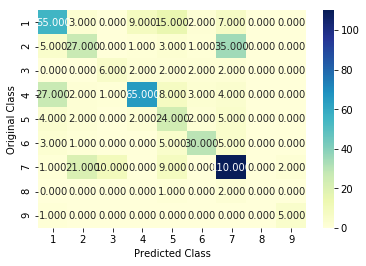

-------------------- Precision matrix (Columm Sum=1) --------------------


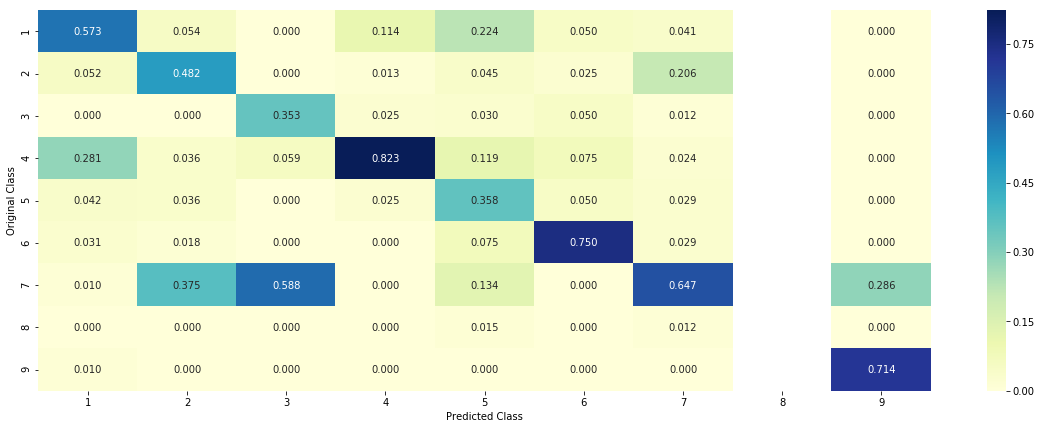

-------------------- Recall matrix (Row sum=1) --------------------


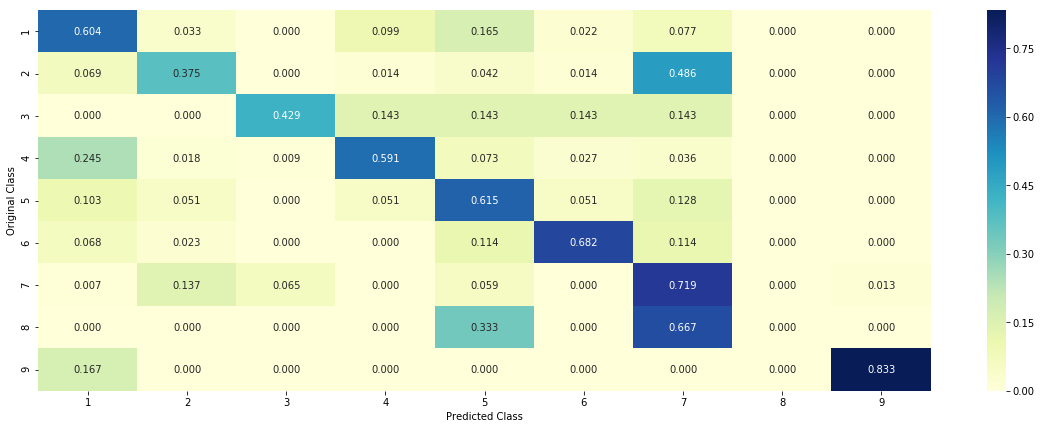

In [64]:
clf = MultinomialNB(alpha=0.001)
clf.fit(train_x_onehotencoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotencoding, train_y)
sig_clf_probs = sig_clf.predict_proba(cv_x_onehotencoding)
# to avoid rounding error while multiplying probabilites we use log-probability estimates
print("Log Loss :",log_loss(cv_y, sig_clf_probs))
print("Number of missclassified point :", np.count_nonzero((sig_clf.predict(cv_x_onehotencoding)- cv_y))/cv_y.shape[0])
plot_confusion_matrix(cv_y, sig_clf.predict(cv_x_onehotencoding.toarray()))

<h2>4.2. K Nearest Neighbour Classification</h2>

<h3>4.2.1. Hyper parameter tuning</h3>

In [65]:
alpha = [5, 11, 15, 21, 31, 41, 51, 99]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = KNeighborsClassifier(n_neighbors=i)
    clf.fit(train_x_responseCoding, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_responseCoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_responseCoding)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 


#Find the best alpha
best_alpha = np.argmin(cv_log_error_array)
clf = KNeighborsClassifier(n_neighbors=alpha[best_alpha])
clf.fit(train_x_responseCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_responseCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_responseCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_responseCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_responseCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))


for alpha = 5
Log Loss : 1.0755862542685914
for alpha = 11
Log Loss : 1.0230073411434637
for alpha = 15
Log Loss : 1.032088463747686
for alpha = 21
Log Loss : 1.0328005921897188
for alpha = 31
Log Loss : 1.058098649045325
for alpha = 41
Log Loss : 1.069691422738874
for alpha = 51
Log Loss : 1.0835446676654308
for alpha = 99
Log Loss : 1.116618509503808
For values of best alpha =  11 The train log loss is: 0.63009621166309
For values of best alpha =  11 The cross validation log loss is: 1.0230073411434637
For values of best alpha =  11 The test log loss is: 1.1053649735753759


<h3>4.2.2. Testing the model with best hyper paramters</h3>

Logloss is 1.0230073411434637
Total number of misclassified points 189
-------------------- Confusion Matrix --------------------


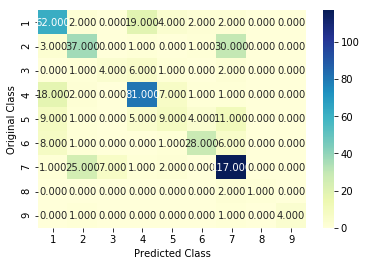

-------------------- Precision matrix (Columm Sum=1) --------------------


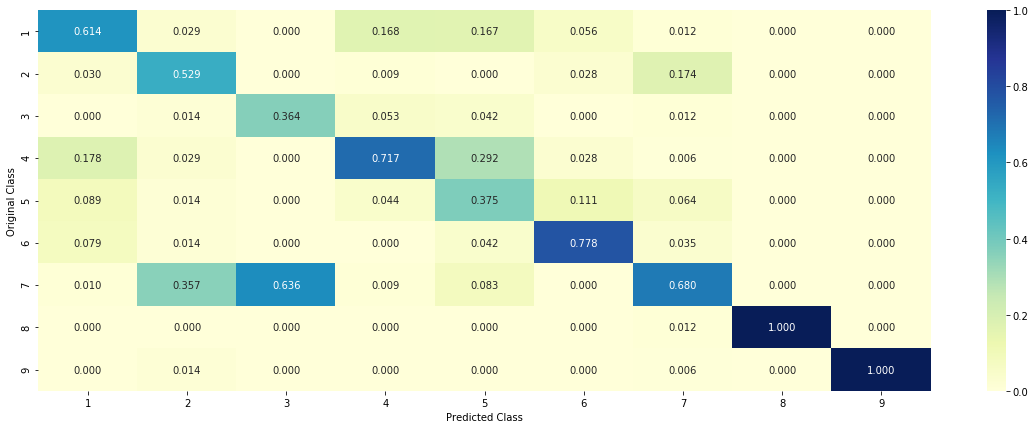

-------------------- Recall matrix (Row sum=1) --------------------


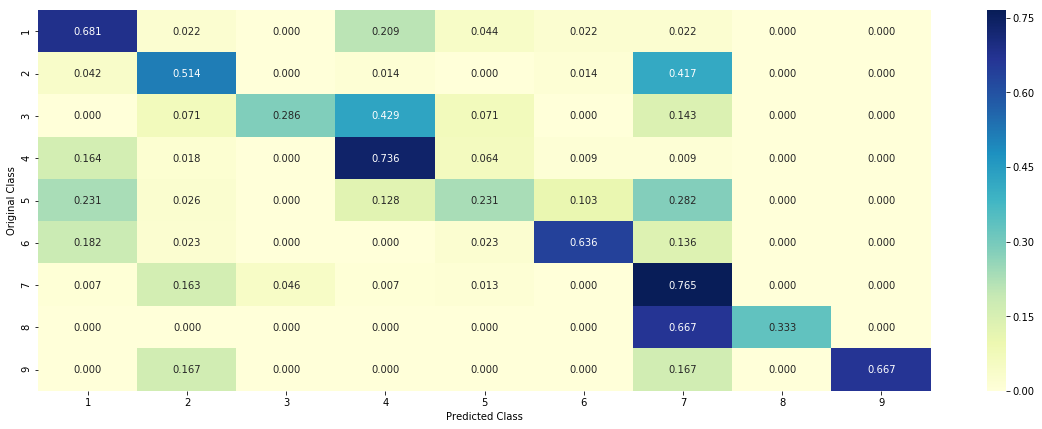

In [66]:
clf = KNeighborsClassifier(n_neighbors=alpha[best_alpha])
predict_and_plot_confusion_matrix(train_x_responseCoding, train_y, cv_x_responseCoding, cv_y, clf)

<h3>4.2.3.Sample Query point -1</h3>

In [67]:
clf=KNeighborsClassifier(n_neighbors=alpha[best_alpha])
clf.fit(train_x_responseCoding,train_y)
sig_clf=CalibratedClassifierCV(clf,method='sigmoid')
sig_clf.fit(train_x_responseCoding,train_y)


test_point_index=1

predicted_cls=sig_clf.predict(test_x_responseCoding[1].reshape(1,-1))
print("Predicted Class is",predicted_cls[0])
print("Actual Class is",test_y[1])
#This returns a tuple of (array representing distance to the points,indices of the nearest neighbors in the population matrix)
neighbbors=clf.kneighbors(test_x_responseCoding[test_point_index].reshape(1,-1),alpha[best_alpha])
print(neighbbors)
print("Indices of the nearest neighbors",neighbbors[1][0])

print("Classes of the nearest neighbors",train_y[neighbbors[1][0]])
print("Frequency of the nearest neighbors",Counter(train_y[neighbbors[1][0]]))

Predicted Class is 4
Actual Class is 4
(array([[0.01036054, 0.01036054, 0.01036054, 0.01036054, 0.01036054,
        0.01036054, 0.01036054, 0.01036054, 0.04261507, 0.04624241,
        0.04769294]]), array([[1650, 1929, 1349,  212,  751,   47, 1729, 1085,  463,  249,  323]]))
Indices of the nearest neighbors [1650 1929 1349  212  751   47 1729 1085  463  249  323]
Classes of the nearest neighbors [3 3 4 3 4 4 4 3 5 4 4]
Frequency of the nearest neighbors Counter({4: 6, 3: 4, 5: 1})


<h3>4.2.4. Sample Query Point-2 </h3>

In [68]:
test_point_index=100

clf=KNeighborsClassifier(n_neighbors=alpha[best_alpha])
clf.fit(train_x_responseCoding,train_y)
sig_clf=CalibratedClassifierCV(clf,method='sigmoid')
sig_clf.fit(train_x_responseCoding,train_y)

predicted_cls=sig_clf.predict(test_x_responseCoding[test_point_index].reshape(1,-1))
print("Predicted Class for best alpha",alpha[best_alpha],"is",predicted_cls[0])
print("Actual Class for best alpha",alpha[best_alpha],"is",test_y[test_point_index])

#Find the nearest neighbors
neighbors=clf.kneighbors(test_x_responseCoding[test_point_index].reshape(1,-1),alpha[best_alpha])
print("Classes of the nearest neighbors",train_y[neighbors[1][0]])

Predicted Class for best alpha 11 is 6
Actual Class for best alpha 11 is 6
Classes of the nearest neighbors [6 6 6 6 6 6 6 6 6 6 6]


<h2>4.3. Logistic Regression</h2>

<h4>4.3.1.1. Hyper paramter tuning</h4>

<h3>4.3.1. With Class balancing</h3>

In [69]:
alpha = [10 ** x for x in range(-6, 3)]
cv_log_array=[]
for index,i in enumerate(alpha):
    clf=SGDClassifier(class_weight='balanced',alpha=i,penalty='l2',loss='log',random_state=42)
    clf.fit(train_x_onehotencoding,train_y)
    sig_clf=CalibratedClassifierCV(clf,method='sigmoid')
    sig_clf.fit(train_x_onehotencoding,train_y)
    pred_y=sig_clf.predict(cv_x_onehotencoding)
    cv_log_array.append(np.round(log_loss(cv_y,sig_clf.predict_proba(cv_x_onehotencoding)),3))
    print("Log loss for alpha",i,"is",cv_log_array[index])
    
#Find best alpha

best_alpha=np.argmin(cv_log_array)
clf=SGDClassifier(class_weight='balanced',alpha=alpha[best_alpha],penalty='l2',loss='log',random_state=42)
clf.fit(train_x_onehotencoding,train_y)
sig_clf=CalibratedClassifierCV(clf,method='sigmoid')
sig_clf.fit(train_x_onehotencoding,train_y)

predict_y = sig_clf.predict_proba(train_x_onehotencoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_onehotencoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_onehotencoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))


Log loss for alpha 1e-06 is 1.417
Log loss for alpha 1e-05 is 1.402
Log loss for alpha 0.0001 is 1.318
Log loss for alpha 0.001 is 1.143
Log loss for alpha 0.01 is 1.176
Log loss for alpha 0.1 is 1.481
Log loss for alpha 1 is 1.69
Log loss for alpha 10 is 1.714
Log loss for alpha 100 is 1.716
For values of best alpha =  0.001 The train log loss is: 0.5994145539900526
For values of best alpha =  0.001 The cross validation log loss is: 1.143134884928441
For values of best alpha =  0.001 The test log loss is: 1.1378448047667122


<h4>4.3.1.2. Testing the model with best hyper paramters</h4>

Logloss is 1.143134884928441
Total number of misclassified points 193
-------------------- Confusion Matrix --------------------


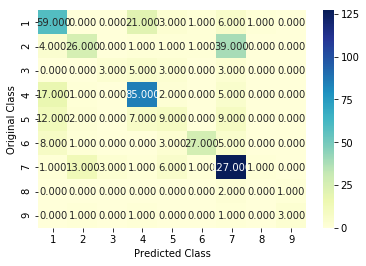

-------------------- Precision matrix (Columm Sum=1) --------------------


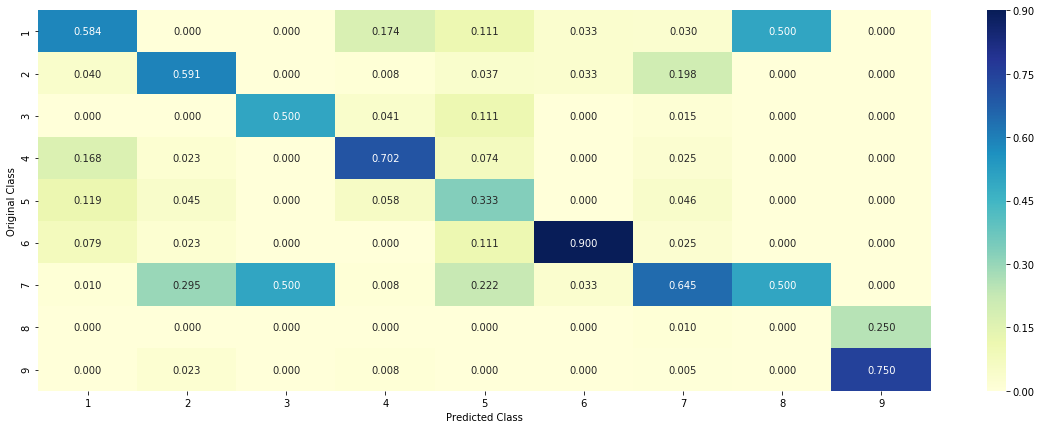

-------------------- Recall matrix (Row sum=1) --------------------


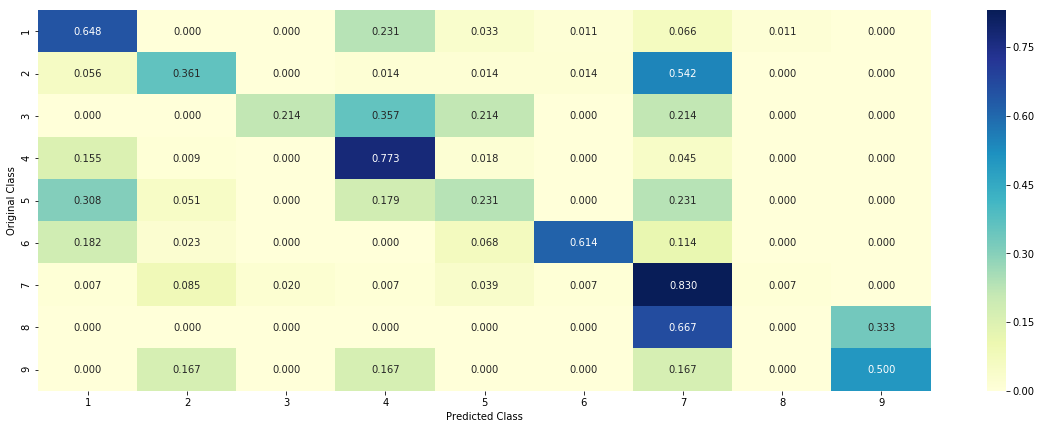

In [70]:
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
predict_and_plot_confusion_matrix(train_x_onehotencoding, y_train, cv_x_onehotencoding, y_cv, clf)

<h4>Observations</h4>

From the precision matrix we can see that naive Bayes perform quite well(for example for class 2 of all the points predicted to be class 2 73% of them actually belong to class 2)

But we also have few misclassified points based on the recall matrix

For example of all the points which were actually in class 8 100% where predicted to be in class 7

But since class 8 has very few points we can ignore them

But there are few misclassifications in class 4

To understand this better we might need to have feature importance

In [71]:
# from tabulate import tabulate
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_x_onehotencoding,y_train)
test_point_index = 1
no_feature = 500
predicted_cls = sig_clf.predict(test_x_onehotencoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotencoding[test_point_index]),4))
print("Actual Class :", y_test[test_point_index])
#clf.coef gives weight of the important words for each class
#We need only the important features of the predicted class(in this case 2 and the index will be 1)
#We print only the first 500 features
indices = np.argsort(-clf.coef_)[predicted_cls-1][:,:no_feature]


Predicted Class : 4
Predicted Class Probabilities: [[0.0256 0.0257 0.3479 0.5349 0.022  0.0137 0.016  0.0071 0.0071]]
Actual Class : 4


<h3>4.3.2. Without Class balancing</h3>

In [72]:
alpha = [10 ** x for x in range(-6, 3)]
cv_log_array=[]
for index,i in enumerate(alpha):
    clf=SGDClassifier(alpha=i,penalty='l2',loss='log',random_state=42)
    clf.fit(train_x_onehotencoding,train_y)
    sig_clf=CalibratedClassifierCV(clf,method='sigmoid')
    sig_clf.fit(train_x_onehotencoding,train_y)
    pred_y=sig_clf.predict(cv_x_onehotencoding)
    cv_log_array.append(np.round(log_loss(cv_y,sig_clf.predict_proba(cv_x_onehotencoding)),3))
    print("Log loss for alpha",i,"is",cv_log_array[index])
    
#Find best alpha

best_alpha=np.argmin(cv_log_array)
clf=SGDClassifier(alpha=alpha[best_alpha],penalty='l2',loss='log',random_state=42)
clf.fit(train_x_onehotencoding,train_y)
sig_clf=CalibratedClassifierCV(clf,method='sigmoid')
sig_clf.fit(train_x_onehotencoding,train_y)

predict_y = sig_clf.predict_proba(train_x_onehotencoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_onehotencoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_onehotencoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))


Log loss for alpha 1e-06 is 1.398
Log loss for alpha 1e-05 is 1.393
Log loss for alpha 0.0001 is 1.327
Log loss for alpha 0.001 is 1.177
Log loss for alpha 0.01 is 1.234
Log loss for alpha 0.1 is 1.414
Log loss for alpha 1 is 1.59
Log loss for alpha 10 is 1.626
Log loss for alpha 100 is 1.63
For values of best alpha =  0.001 The train log loss is: 0.6068953016110525
For values of best alpha =  0.001 The cross validation log loss is: 1.1767947478617244
For values of best alpha =  0.001 The test log loss is: 1.1846271962466492


<h4>4.3.2.2. Testing model with best hyper parameters</h4>

Logloss is 1.1767947478617244
Total number of misclassified points 188
-------------------- Confusion Matrix --------------------


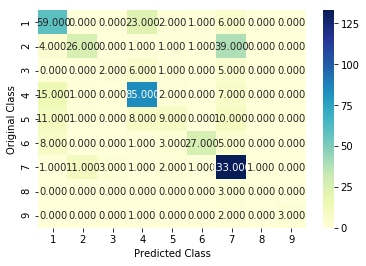

-------------------- Precision matrix (Columm Sum=1) --------------------


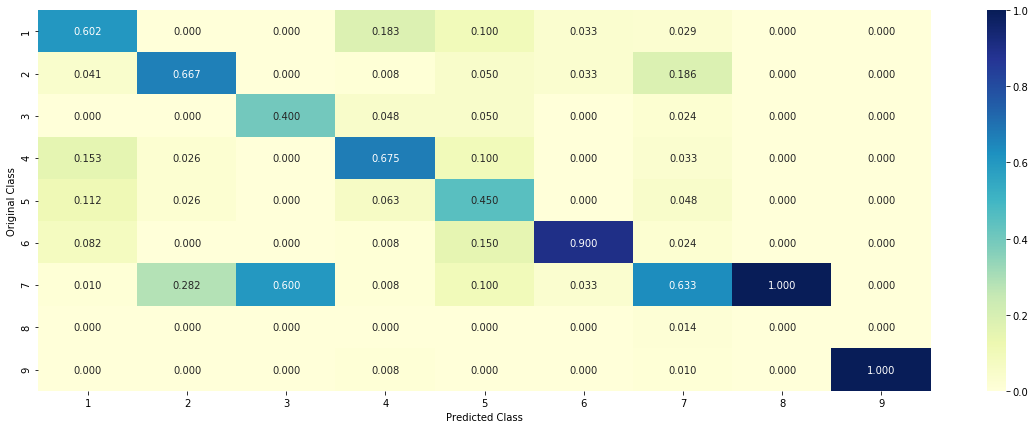

-------------------- Recall matrix (Row sum=1) --------------------


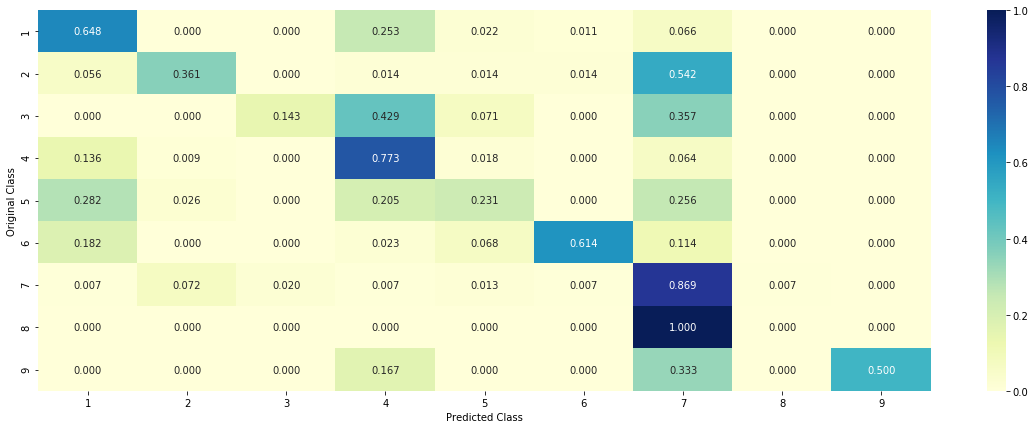

In [73]:
clf = SGDClassifier( alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
predict_and_plot_confusion_matrix(train_x_onehotencoding, y_train, cv_x_onehotencoding, y_cv, clf)

<h2>4.4. Linear Support Vector Machines</h2>

In [74]:
alpha = [10 ** x for x in range(-6, 3)]
cv_log_array=[]
for index,i in enumerate(alpha):
    clf=SGDClassifier(class_weight='balanced',alpha=i,penalty='l2',loss='hinge',random_state=42)
    clf.fit(train_x_onehotencoding,train_y)
    sig_clf=CalibratedClassifierCV(clf,method='sigmoid')
    sig_clf.fit(train_x_onehotencoding,train_y)
    pred_y=sig_clf.predict(cv_x_onehotencoding)
    cv_log_array.append(np.round(log_loss(cv_y,sig_clf.predict_proba(cv_x_onehotencoding)),3))
    print("Log loss for alpha",i,"is",cv_log_array[index])
    
#Find best alpha

best_alpha=np.argmin(cv_log_array)
clf=SGDClassifier(class_weight='balanced',alpha=alpha[best_alpha],penalty='l2',loss='hinge',random_state=42)
clf.fit(train_x_onehotencoding,train_y)
sig_clf=CalibratedClassifierCV(clf,method='sigmoid')
sig_clf.fit(train_x_onehotencoding,train_y)

predict_y = sig_clf.predict_proba(train_x_onehotencoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_onehotencoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_onehotencoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))


Log loss for alpha 1e-06 is 1.4
Log loss for alpha 1e-05 is 1.417
Log loss for alpha 0.0001 is 1.361
Log loss for alpha 0.001 is 1.28
Log loss for alpha 0.01 is 1.159
Log loss for alpha 0.1 is 1.422
Log loss for alpha 1 is 1.712
Log loss for alpha 10 is 1.717
Log loss for alpha 100 is 1.717
For values of best alpha =  0.01 The train log loss is: 0.7112642914045629
For values of best alpha =  0.01 The cross validation log loss is: 1.1587361652429438
For values of best alpha =  0.01 The test log loss is: 1.1947254553489457


Logloss is 1.1984310451717801
Total number of misclassified points 190
-------------------- Confusion Matrix --------------------


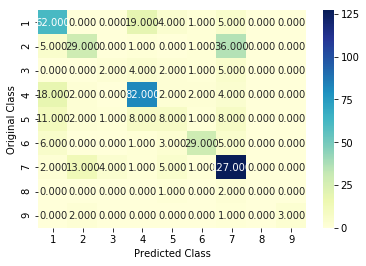

-------------------- Precision matrix (Columm Sum=1) --------------------


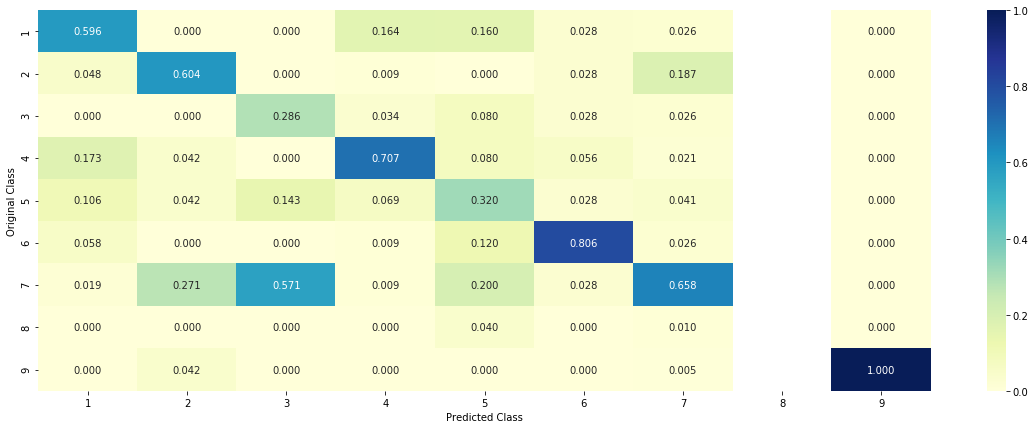

-------------------- Recall matrix (Row sum=1) --------------------


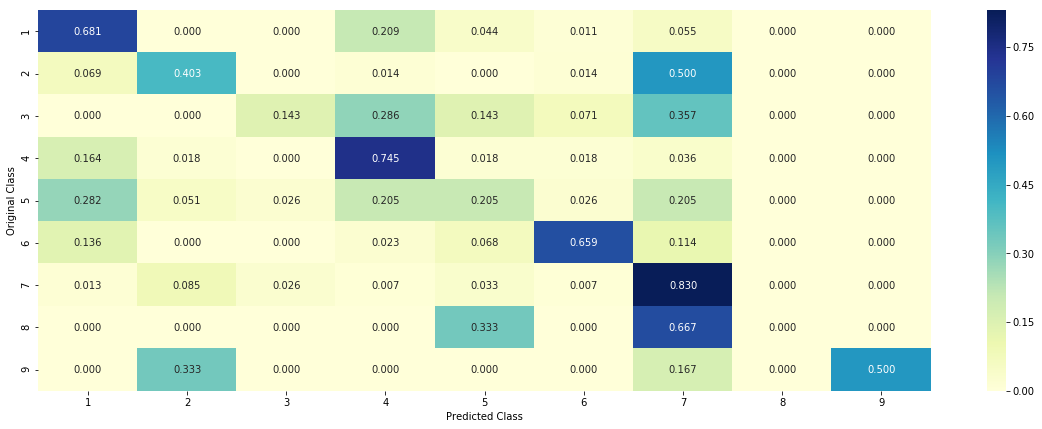

In [75]:
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='hinge', random_state=42)
predict_and_plot_confusion_matrix(train_x_onehotencoding, y_train, cv_x_onehotencoding, y_cv, clf)

<h2>4.5 Random Forest Classifier</h2>

In [76]:
alpha = [100,200,500,1000,2000]
max_depth = [5, 10]

for index,i in enumerate(alpha):
    for j in max_depth:
        clf=RandomForestClassifier(n_estimators=i, criterion='gini', max_depth=j, random_state=42, n_jobs=-1)
        clf.fit(train_x_onehotencoding,train_y)
        sig_clf=CalibratedClassifierCV(clf,method='sigmoid')
        sig_clf.fit(train_x_onehotencoding,train_y)
        pred_y=sig_clf.predict_proba(cv_x_onehotencoding)
        cv_log_array.append(np.round(log_loss(cv_y,sig_clf.predict_proba(cv_x_onehotencoding)),3))
        print("Log loss for alpha",i,' ',j,"is",cv_log_array[index])
    
#Find best alpha

best_alpha=np.argmin(cv_log_array)
clf=RandomForestClassifier(n_estimators=alpha[best_alpha], criterion='gini', max_depth=j, random_state=42, n_jobs=-1)
clf.fit(train_x_onehotencoding,train_y)
sig_clf=CalibratedClassifierCV(clf,method='sigmoid')
sig_clf.fit(train_x_onehotencoding,train_y)



Log loss for alpha 100   5 is 1.4
Log loss for alpha 100   10 is 1.4
Log loss for alpha 200   5 is 1.417
Log loss for alpha 200   10 is 1.417
Log loss for alpha 500   5 is 1.361
Log loss for alpha 500   10 is 1.361
Log loss for alpha 1000   5 is 1.28
Log loss for alpha 1000   10 is 1.28
Log loss for alpha 2000   5 is 1.159
Log loss for alpha 2000   10 is 1.159


CalibratedClassifierCV(base_estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=10, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=2000, n_jobs=-1,
            oob_score=False, random_state=42, verbose=0, warm_start=False),
            cv=3, method='sigmoid')

In [77]:
predict_y = sig_clf.predict_proba(train_x_onehotencoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_onehotencoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_onehotencoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))


For values of best alpha =  2000 The train log loss is: 0.6947838390989749
For values of best alpha =  2000 The cross validation log loss is: 1.1648210302748554
For values of best alpha =  2000 The test log loss is: 1.1622150844615735
